# Entrega 1, Grupo 02 - Arboles de decisión

- Santiago Alaniz, 5082647-6, santiago.alaniz@fing.edu.uy
- Bruno De Simone, 4914555-0, bruno.de.simone@fing.edu.uy
- María Usuca, 4891124-3, maria.usuca@fing.edu.uy



## Objetivo

Implementar un modelo que explique la deserción de estudiantes en la universidad.
 
Se pide:

- **(a)** Implementar una variante del algoritmo `ID3` agregandole los siguientes *hiperparametros*:
    - **i)** `min_samples_split`: cantidad mínima de ejemplos para generar un nuevo nodo; en caso de que no se llegue a la cantidad requerida, se debe formar una hoja.
    - **ii)** `min_split_gain`: ganancia mínima requerida para partir por un atributo; si ningún atributo llega a ese valor, se debe formar una hoja.
- **(b)** Utilizar el algoritmo implementado en **(a)** para construir un arbol de decision, evaluar resultados utilizando el dataset provisto.
- **(c)** Discuta como afecta la variacion de los hiperparametros con los modelos obtenidos.
- **(d)** Corra los algoritmos de `scikit-learn DecisionTreeClassifier, RandomForestClassifer` y compare los resultados.

El dataset que vamos a considerar (con su debido preprocesamiento) es *Predict students dropout and accademic success* con **36 atributos y mas de 4000 instancias.**

## Diseño

El apartado de diseño engloba todas las decisiones que tomamos a la hora de cumplir con las subtareas planteadas en la seccion anterior. 

Podemos identificar las siguientes etapas:

- **Carga de datos y Particionamiento**: Inicialización de los datos de los archivos CSV en un DataFrame de Pandas.
- **Pre-procesamiento de datos**: Transformaciones necesarias para que los datos puedan ser utilizados por el modelo.
- **Algoritmo**: Comentarios sobre la implementacion del algoritmo asi como las decisiones tomadas para su implementacion.
- **Evaluacion**: Prueba del modelo con diferentes hiperparametros.

### Carga de datos y particionamiento

En este apartado vamos a inicializar los datos siguiendo un esquema clásico de aprendizaje automático:

- **Carga de datos**: Cargamos los datos desde el fichero `csv` y los almacenamos en un `DataFrame` de `pandas`.
- **Particionamiento**: Particionamos los datos en dos conjuntos con `train_test_split` de `sklearn`.
    - `train` para entrenar el modelo.
    - `test` para evaluar el modelo.
    - `test` para evaluar el modelo final.

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split

CSV_PATH = './assets/data.csv'
SEED_NUMBER = 42069
TEST_SIZE = 0.4
test_SIZE = 0.5

data = pd.read_csv(CSV_PATH, sep=';')
train, test = train_test_split(data, test_size= TEST_SIZE, random_state= SEED_NUMBER)
test, devel = train_test_split(train, test_size= test_SIZE, random_state= SEED_NUMBER)


print(f'< data: {data.shape[0]} >')
print(f'< train: {train.shape[0]}, devel: {devel.shape[0]}, test: {test.shape[0]} >')
train.head()

< data: 4424 >
< train: 2654, devel: 1327, test: 1327 >


,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
4275,1,17,1,9119,1,1,141.0,1,37,1,...,0,5,10,3,12.333333,3,7.6,2.6,0.32,Enrolled
552,1,43,1,9070,1,1,115.0,1,12,12,...,3,8,11,3,13.666667,0,15.5,2.8,-4.06,Dropout
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1621,1,1,1,9085,1,1,126.0,1,38,37,...,0,5,5,5,13.000000,0,10.8,1.4,1.74,Graduate
2147,1,1,6,9254,1,1,129.0,1,38,19,...,0,6,11,4,12.500000,0,8.9,1.4,3.51,Graduate


#### Redefinición de los valores del atributo objetivo `Target`.

El atributo objetivo `Target` es un atributo categórico que indica el desenlace del estudiante en su vida académica. Este atributo tiene 3 posibles valores: 

- `Enrolled` (inscripto)
- `Dropout` (abandono)
- `Graduate` (graduado).

La idea es construir un modelo sobre la diserción de los estudiantes, por lo que se decide agrupar los valores `Enrolled` y `Graduate` en un solo valor. 

-  0 &rarr; `Dropout`
-  1 &rarr; `Enrolled` o `Graduate`

**Nota**: 
La siguiente redefinición de atributos genera un desbalance en el atributo `Target`. De todas formas, continuaremos con el análisis.

In [8]:
for df in [train, devel, test]:
    df['Target'] = df['Target'].apply(lambda x: 0 if x == 'Dropout' else 1)

train['Target'].value_counts()

Target
1    1792
0     862
Name: count, dtype: int64

#### Preprocesamiento de atributos continuos.

La [discretización](https://en.wikipedia.org/wiki/Data_binning) provee un mecanismo para particionar valores continuos en un número finito de valores discretos.

De los [36 atributos presentes](https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success) en el dataset, estos son listados como continuos:

- `Previous qualification (grade)`
- `Admission grade`
- `Unemployment rate`
- `Inflation rate`
- `GDP`

Para discretizar estos atributos, utlizaremos el modulo `scikit-learn.preprocessing`. 

En particular, la clase [`KBinsDiscretizer`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.KBinsDiscretizer.html#sklearn.preprocessing.KBinsDiscretizer) con los siguientes parámetros:

- `encode= 'ordinal'` (codificación de los bins) devuelve un array de enteros indicando a que bin pertenece cada valor.
- `strategy='kmeans'` (estrategia de discretizacion) utiliza el algoritmo de [k-means](https://en.wikipedia.org/wiki/K-means_clustering) para determinar los bins. 

Finalmente, identificar estos atributos en el dataset es una tarea sencilla, ya que son los únicos del tipo `float64`.

***Nota***: 

Hay un error en la [documentación de los datos](https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success), figuran como discretos dos campos representados con `float64`:

- `Curricular units 1st sem (grade)`
- `Curricular units 2nd sem (grade)` 

Decidimos discretizarlos de todas formas, ya que algunas de las entradas tienen valores no enteros.

In [9]:
from sklearn.preprocessing import KBinsDiscretizer

float64_cols = data.select_dtypes(include=['float64']).columns

for float64_col in float64_cols:
    float64_col_discretizer = KBinsDiscretizer(subsample=None, encode='ordinal', strategy='kmeans')
    train[[float64_col]] = float64_col_discretizer.fit_transform(train[[float64_col]]).astype(int)
    devel[[float64_col]] = float64_col_discretizer.transform(devel[[float64_col]]).astype(int)
    test[[float64_col]] = float64_col_discretizer.transform(test[[float64_col]]).astype(int)

train[float64_cols].head()

,Previous qualification (grade),Admission grade,Curricular units 1st sem (grade),Curricular units 2nd sem (grade),Unemployment rate,Inflation rate,GDP
4275,2,2,2,2,0,3,2
552,0,1,2,3,4,3,0
0,1,2,0,0,1,2,3
1621,1,1,1,2,1,2,3
2147,1,1,2,2,0,2,4


#### Comentario sobre el resto de los valores (discretos)

Los valores discretos son ideales para `ID3` porque el algoritmo puede manejarlos directamente sin necesidad de transformaciones adicionales. Sin embargo, es crucial tener en cuenta el número de valores únicos que un atributo discreto puede tener.

Somos conscientes que no existe un "buen número" de valores discretos distintos para un atributo en un árbol de decisión como ID3.
Depende de varios factores, incluidos el tamaño del conjunto de datos, la complejidad del problema y el riesgo de sobreajuste. 

Además otro factor a tomar en cuenta es que los valores discretos pueden categorizar elementos complejos donde su valor numérico no tenga correlación con su valor semántico. Por ejemplo, la columna `Nationality` representa con un entero distintos países, si quisieramos categorizar ese valor de forma significativa tendríamos que construir supercategorías para los países (por ejemplo 0-Europa, 1-America, etc).

Otra alternativa es aplicar [one-hot encoding](https://datagy.io/sklearn-one-hot-encode/) a los valores discretos, pero esto aumentaría la dimensionalidad del dataset y podría generar problemas de performance.

La conclusión final es que el procesamiento de valores discretos es una tarea que excede el objetivo de este laboratorio, por eso decidimos no aplicar ningún preprocesamiento a los valores discretos.

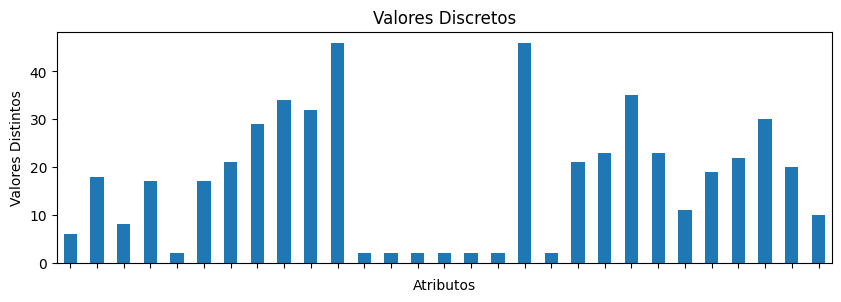

In [10]:
import matplotlib.pyplot as plt

int64_cols = data.select_dtypes(include=['int64']).columns
unique_values = data[int64_cols].nunique()

plt.figure(figsize=(10, 3))
ax = unique_values.plot(kind='bar')
plt.title('Valores Discretos')
plt.xlabel('Atributos')
plt.ylabel('Valores Distintos')
ax.set_xticklabels([])
plt.show()

### Algoritmo

El algoritmo a desarrollar es `ID3` como se presento en el teórico, con la incorporación de ciertos meta-parametros que buscan evitar el sobreajuste del modelo.

Para lograr este objetivo, se tuvo en consideración las siguientes subtareas:

1. Sobre las variables/estructuras necesarias para implementar `ID3` (Mitchell, 97, p86).
2. `ID3_utils.py`: Un modulo con estructuras/funciones auxiliares para la implementación de `ID3`.
3. `src.G02DecisionTrees.ID3Classifier`: Nuestro algoritmo inspirado en los clasificadores de `sklearn`..

#### Sobre las variables necesarias para implementar `ID3` (Mitchell, 97, p86).

Para implementar `ID3` necesitamos definir las siguientes variables:

Entradas:

- `Examples`: conjunto de ejemplos de entrenamiento (`train`).
- `Target_attribute`: atributo objetivo (`Target`).
- `Attributes`: conjunto de atributos (el resto de las columnas).

Estructura de Datos y Funciones Auxiliares:

- `node`: estructura de datos que representa un nodo del arbol.
- `max_gain_attr`: función que devuelve el atributo con mayor ganancia de información.
- `attributes_values`: diccionario que mapea atributos con todos sus valores posibles.


Para obtener `attributes_values` recorremos todos los atributos y obtenemos sus valores únicos. Hay que tener en cuenta que los atributos continuos fueron discretizados, por lo que sus valores son enteros que se encuentran en un rango acotado. (Preprocesamiento de atributos continuos).

El resto de las Estrucutras de Datos y Funciones Auxiliares se encuentran en el modulo `ID3_utils.py`.



In [11]:
import numpy as np

int64_cols = data.select_dtypes(include=['int64']).columns
attrs_values = {attr: sorted(data[attr].unique()) for attr in int64_cols}
float64_cols = data.select_dtypes(include=['float64']).columns
attrs_values.update({col: list(range(5)) for col in float64_cols})

print(f'attrs: {len(attrs_values.keys())}, Ejemplo de algunos valores de atributos discretos: \n')
for k in list(attrs_values.keys())[:5]: print(f"{k}: {attrs_values[k]}")

attrs: 36, Ejemplo de algunos valores de atributos discretos: 

Marital status: [1, 2, 3, 4, 5, 6]
Application mode: [1, 2, 5, 7, 10, 15, 16, 17, 18, 26, 27, 39, 42, 43, 44, 51, 53, 57]
Application order: [0, 1, 2, 3, 4, 5, 6, 9]
Course: [33, 171, 8014, 9003, 9070, 9085, 9119, 9130, 9147, 9238, 9254, 9500, 9556, 9670, 9773, 9853, 9991]
Daytime/evening attendance	: [0, 1]


#### `ID3_utils.py`: Un módulo con estructuras/funciones auxiliares para la implementacion de `ID3`.

Este módulo de Python está diseñado para implementar árboles de decisión utilizando el algoritmo ID3. A continuación se describen los componentes principales:

- `ID3Node`: Esta es una clase que representa un nodo en el árbol de decisión. Cada nodo tiene una etiqueta (`label`) que indica el atributo que se está evaluando en ese nodo, y una ganancia de información (`info_gain`) que indica cuánta incertidumbre se reduce al dividir el conjunto de datos según ese atributo.
- `node`: Esta es una función auxiliar que facilita la creación de nuevos nodos. Acepta una etiqueta y una ganancia de información como argumentos y devuelve una instancia de `ID3Node`.
- `entropy`: Esta función calcula la entropía de un conjunto de datos dado un atributo objetivo (`attr_tget`). La entropía es una medida de la incertidumbre o el desorden en los datos.
- `max_gain_attr`: Esta función determina qué atributo tiene la máxima ganancia de información cuando se utiliza para evaluar el mejor nodo candidato.
- `evaluate`: Esta función evalúa un conjunto de datos y busca en el árbol de decisión para determinar la clase de cada ejemplo. Devuelve una lista de predicciones.

In [12]:
from src.ID3_utils import max_gain_attr, node

attr, gain = max_gain_attr(train, 'Target', attrs_values)
id3_node = node(attr, info_gain= gain)
id3_node.children[attrs_values[attr][0]] = node('Nationality', 0.02)

print(f"node: {id3_node.label, id3_node.info_gain}")
print(f"child: {id3_node.children[0].label, id3_node.children[0].info_gain}")

node: ('Curricular units 2nd sem (approved)', 0.32494020042584515)
child: ('Nationality', 0.02)


#### `src.G02DecisionTrees.ID3Classifier`: Nuestro algoritmo inspirado en los clasificadores de `sklearn`.

Nuestro algoritmo esta encapsulado en una clase clasificadora que está diseñada/inspirada en base a los clasificadores de `scikit-learn`.
La principal motivacion para hacerlo de esta forma es el objetivo de comparar los resultados de nuestro algoritmo con los de `scikit-learn DecisionTreeClassifier, RandomForestClassifer`.

Entonces, nos parecio más que acertado modelar esta clase como si se tratara de una clase más de `scikit-learn.`

**Clase ID3Classifier**: Define el clasificador ID3.

- `__init__`: Inicializa el clasificador con los meta-parametros. 
  - `min_samples_split` y `min_split_gain`: requeridas por la letra del obligatorio, limitan el crecimiento del arbol. 
  - `attr_values`, `attrs` necesarias para implementar `ID3` (Mitchell, 97, p86).
- `predict`: Realiza predicciones utilizando el árbol de decisión entrenado.
- `score`: Calcula la precisión del modelo.

La clase `ID3Classifier` implmeneta funciones típicas de `scikit-learn`:

- El método `fit` toma un DataFrame `X`, una serie `y` como entrada y construye un árbol de decisión.
- El método `predict` utiliza el árbol para hacer predicciones en un nuevo conjunto de datos.
- El método `score` evalúa la precisión del modelo utilizando `scikit-learn accuracy_score`.
    
**Método privado `__id3`**: Implementa el algoritmo ID3 recursivamente para construir el árbol de decisión.

```python
## Mitchell, p. 68
def __id3(self, exs, attr_tget, attrs):
    if exs[attr_tget].nunique() == 1: return utils.node(1)
    if exs[attr_tget].nunique() == 0: return utils.node(0)
    if len(attrs) == 0: return utils.node(exs[attr_tget].mode()[0])

    _attrs_values = { k: self.attrs_values[k] for k in attrs }
    best_attr, gain = utils.max_gain_attr(exs, attr_tget, _attrs_values)
    
    if gain <= self.min_split_gain: return utils.node(exs[attr_tget].mode()[0])
    
    node = utils.node(best_attr, gain)
    best_attr_values = self.attrs_values[best_attr]
    
    for attr_val in best_attr_values:
        exs_i = exs[exs[best_attr] == attr_val]

        if exs_i.shape[0] <= self.min_samples_split: 
          node.children[attr_val] = utils.node(exs[attr_tget].mode()[0])
        else:
          attrs_i = [attr for attr in attrs if attr != best_attr]
          node.children[attr_val] = self.__id3(exs_i, attr_tget, attrs_i)
    
    return node
```

In [13]:
from src.G02_decision_trees import ID3Classifier

train_X, train_y = train.drop(columns=['Target']), train['Target']
devel_X, devel_y = devel.drop(columns=['Target']) , devel['Target']

G02_id3 = ID3Classifier(attrs_values= attrs_values, min_samples_split= 133, min_split_gain= 0.032)
G02_id3.fit(train_X, train_y)
G02_id3.score(devel_X, devel_y)

0.825923134890731



### Evaluación
- Qué conjunto de métricas se utilizan para la evaluación de la solución y su definición
- Sobre qué conjunto(s) se realiza el entrenamiento, ajuste de la solución, evaluación, etc. Explicar cómo se construyen estos conjuntos.

## Experimentación

- Presentar los distintos experimentos que se realizan y los resultados que se obtienen.

In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score

train_X, train_y = train.drop(columns=['Target']), train['Target']
devel_X, devel_y = devel.drop(columns=['Target']) , devel['Target']

# Crear y entrenar el modelo DecisionTreeClassifier
dt_clf = DecisionTreeClassifier()
dt_clf.fit(train_X, train_y)
pred_y = dt_clf.predict(devel_X)

#print (dt_clf.score(devel_X,devel_y))

#plt.figure(figsize=(20,20))
#plot_tree(dt_clf,max_depth=2)
#plt.show()

recall_score(devel_y, pred_y)

1.0

## Conclusión

Una breve conclusión del trabajo realizado. Por ejemplo: 
- ¿cuándo se dieron los mejores resultados del jugador?
- ¿encuentra alguna relación con los parámetros / oponentes/ atributos elegidos?
- ¿cómo mejoraría los resultados?

## Cosas de bruno (posiblemente desactualizado ☠️⚰️)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from src.G02_algorithm import CustomID3Classifier
import matplotlib.pyplot as plt

X_train, y_train = train.drop(columns=['Target']), train['Target']

custom_clf = CustomID3Classifier(MIN_SAMPLES_SPLIT=0, MIN_SPLIT_GAIN=0)
custom_clf.fit(X_train, y_train)

In [ ]:
X_test, y_test = test.drop(columns=['Target']), test['Target']
predictions = custom_clf.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")

conf_matrix = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot(cmap=plt.cm.Blues, values_format='.2f')

plt.title("Confusion Matrix")
plt.show()

#### Comparación de salidas

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Calcular matrices de confusión
cm_decision_tree = confusion_matrix(y_test, y_pred_decision_tree)
cm_random_forest = confusion_matrix(y_test, y_pred_random_forest)

## Crear objetos ConfusionMatrixDisplay
cmd_decision_tree = ConfusionMatrixDisplay(confusion_matrix=cm_decision_tree, display_labels=decision_tree_clf.classes_)
cmd_random_forest = ConfusionMatrixDisplay(confusion_matrix=cm_random_forest, display_labels=random_forest_clf.classes_)

# Mostrar las matrices de confusión
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

cmd_decision_tree.plot(cmap=plt.cm.Blues, ax=axes[0])
axes[0].set_title("Matriz de Confusión - Decision Tree")

cmd_random_forest.plot(cmap=plt.cm.Blues, ax=axes[1])
axes[1].set_title("Matriz de Confusión - Random Forest")

plt.tight_layout()
plt.show()